In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from htc.context.models.context_evaluation import baseline_granularity_comparison
from htc.context.settings_context import settings_context
from htc.fonts.set_font import set_font
from htc.settings_seg import settings_seg

In [2]:
df = baseline_granularity_comparison(
    baseline_timestamp=settings_seg.model_comparison_timestamp,
    glove_runs_hsi=settings_context.glove_runs_granularities,
    glove_runs_rgb=settings_context.glove_runs_granularities_rgb,
)
df.head()

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/pixel/2022-02-03_22-58-44_generated_default_model_comparison                 

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/pixel/2022-02-03_22-58-44_generated_default_rgb_model_compari                
son                                                                                                                     

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_context/training/superpixel_classification/2024-07-24_15-20-46_default                         

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_context/training/superpixel_classification/2024-07-24_15-20-46_default_rgb                     

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/patch/2022-02-03_22-58-44_generated_default_model_comparison                 

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/patch/2022-02-03_22-58-44_generated_default_rgb_model_compari                
son                                                                                                                     

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/patch/2022-02-03_22-58-44_generated_default_64_model_comparis                
on                                                                                                                      

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/patch/2022-02-03_22-58-44_generated_default_64_rgb_model_comp                
arison                                                                                                                  

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_model_comparison                 

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:481
/mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_rgb_model_compari                
son                                                                                                                     

,network,dataset,modality,label_index,dice_metric,label_name
0,pixel,semantic,HSI,6,0.412635,stomach
1,pixel,semantic,HSI,5,0.827066,small_bowel
2,pixel,semantic,HSI,4,0.827302,colon
3,pixel,semantic,HSI,3,0.852646,liver
4,pixel,semantic,HSI,8,0.502975,gallbladder


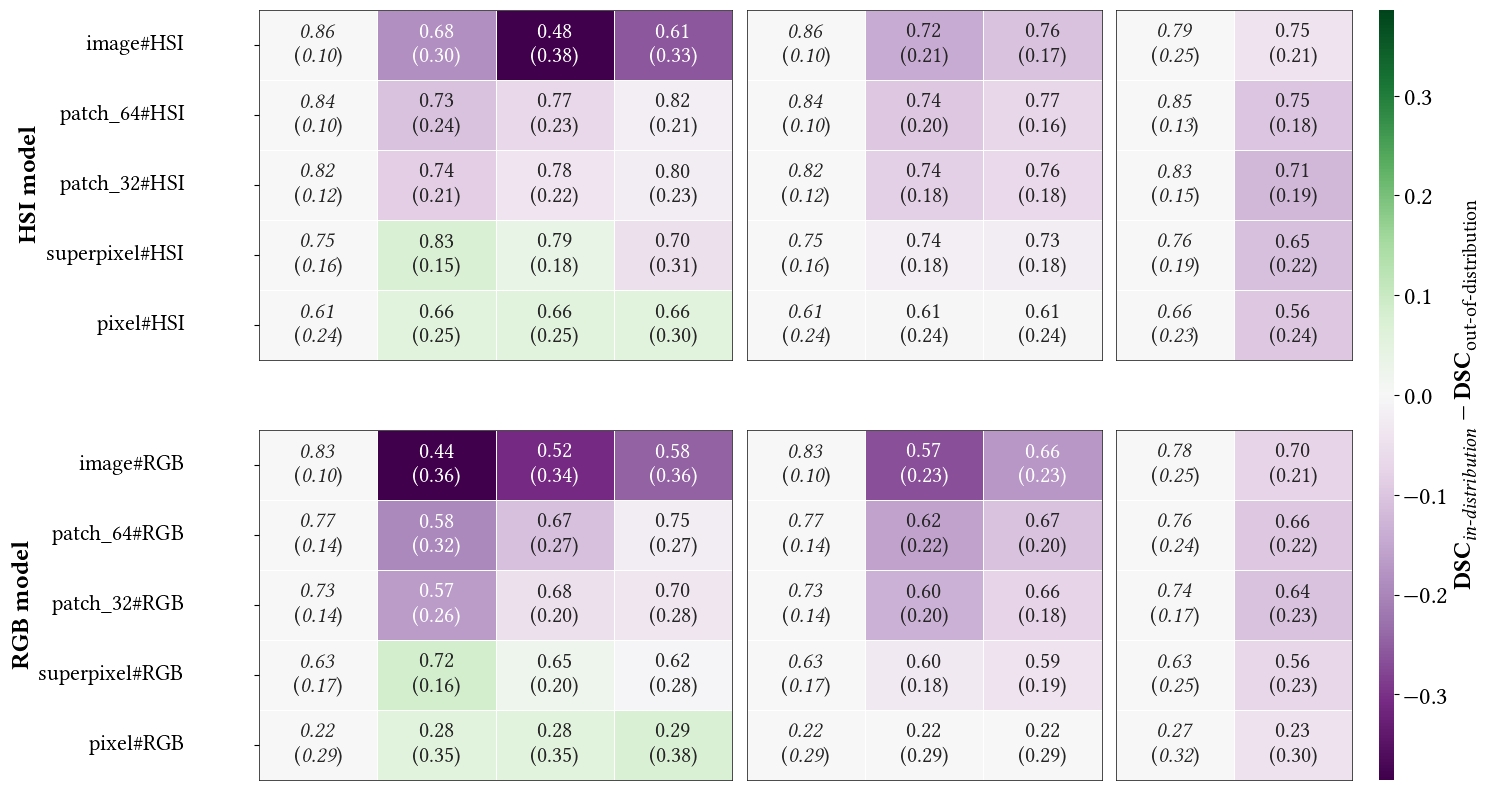

In [3]:
def granularities_comparison_figure(metric_name: str, metric_name_short: str) -> plt.Figure:
    df_agg = df.groupby(["network", "dataset", "modality"], as_index=False).agg(
        metric_mean=(metric_name, "mean"),
        metric_std=(metric_name, "std"),
    )

    # Repeat reference for removal scenario
    semantic2 = df_agg[df_agg.dataset == "semantic"].copy()
    semantic2.replace({"dataset": {"semantic": "semantic2"}}, inplace=True)
    df_agg = pd.concat([df_agg, semantic2], ignore_index=True)

    networks = list(settings_context.glove_runs_granularities.keys())
    datasets = list(settings_context.task_name_mapping.keys())
    datasets.insert(datasets.index("removal_0"), "semantic2")

    network_renaming = {
        "superpixel_classification": "superpixel",
    }

    fontsize = 18
    set_font(fontsize)
    # Text with TeX should look as close as possible as the default text with matplotlib
    plt.rcParams.update({
        "text.usetex": True,
        "text.latex.preamble": r"""
            \usepackage[T1]{fontenc}
            \usepackage{libertinus,libertinust1math}
            \usepackage{microtype}
            """,
    })
    fig, axes = plt.subplots(2, 3, figsize=(17, 10), gridspec_kw={"width_ratios": [4, 3, 2], "wspace": 0.04})

    for modality, axes_cols in zip(df_agg.modality.unique(), axes):
        df_agg_modality = df_agg[df_agg.modality == modality]
        label_matrix = np.full(
            (
                len(df_agg_modality.network.unique()),
                len(df_agg_modality.dataset.unique()),
            ),
            np.nan,
        )
        label_matrix_std = np.full(
            (
                len(df_agg_modality.network.unique()),
                len(df_agg_modality.dataset.unique()),
            ),
            np.nan,
        )
        for _, row in df_agg_modality.iterrows():
            network_idx = networks.index(row.network)
            dataset_idx = datasets.index(row.dataset)
            label_matrix[network_idx, dataset_idx] = row.metric_mean
            label_matrix_std[network_idx, dataset_idx] = row.metric_std

        # Global diff for the shared colorbar
        diff_isolation = (
            label_matrix[:, : datasets.index("masks_isolation") + 1] - label_matrix[:, : datasets.index("semantic") + 1]
        )
        diff_removal = (
            label_matrix[:, datasets.index("semantic2") : datasets.index("removal_cloth") + 1]
            - label_matrix[:, datasets.index("semantic2") : datasets.index("semantic2") + 1]
        )
        diff_glove = (
            label_matrix[:, datasets.index("no-glove") :]
            - label_matrix[:, datasets.index("no-glove") : datasets.index("no-glove") + 1]
        )
        label_matrix_diff = np.concatenate([diff_isolation, diff_removal, diff_glove], axis=1)

        for ax, (start_idx, end_idx) in zip(
            axes_cols,
            [
                (0, datasets.index("masks_isolation")),
                (datasets.index("semantic2"), datasets.index("removal_cloth")),
                (datasets.index("no-glove"), datasets.index("glove")),
            ],
        ):
            mat = label_matrix[:, start_idx : end_idx + 1]
            mat_std = label_matrix_std[:, start_idx : end_idx + 1]
            diff = mat - mat[:, :1]

            # Absolute scores in the matrix
            text = np.vectorize(
                lambda x_mean, x_std, base: (
                    "\\textit{" + f"{x_mean:.2f}" + "}\n(\\textit{" + f"{x_std:.2f}" + "})"
                    if base
                    else f"{x_mean:.2f}\n({x_std:.2f})"
                )
            )(mat, mat_std, mat == mat[:, :1])

            res = sns.heatmap(
                diff,
                annot=text,
                fmt="s",
                linewidths=0.5,
                xticklabels=False,
                yticklabels=[network_renaming.get(n, n) + "\\#" + modality for n in networks],
                annot_kws={"size": fontsize - 2},
                cmap=settings_context.cmap_diverging,
                center=0,
                vmin=-np.max(np.abs(label_matrix_diff)),
                vmax=np.max(np.abs(label_matrix_diff)),
                cbar=False,
                ax=ax,
            )

            if start_idx != 0:
                ax.set_yticks([])

            # Make frame visible
            for _, spine in ax.spines.items():
                spine.set_linewidth(0.5)
                spine.set_visible(True)

        axes_cols[0].tick_params(axis="y", which="major", pad=50)

        for t in axes_cols[0].yaxis.get_ticklabels():
            t.set_rotation(0)

    axes[0, 0].set_ylabel("$\\textbf{HSI model}$")
    axes[1, 0].set_ylabel("$\\textbf{RGB model}$")

    cbar = fig.colorbar(res.get_children()[0], ax=axes.ravel().tolist(), aspect=50, pad=0.02)
    cbar.set_label(
        "$\\textbf{"
        + metric_name_short
        + "}_{\\textit{in-distribution}} - \\textbf{"
        + metric_name_short
        + "}_{\\textrm{out-of-distribution}}$"
    )
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(labelsize=fontsize)

    fig.savefig(
        settings_context.paper_extended_dir / f"spatial_granularities_{metric_name_short}_base.pdf", bbox_inches="tight"
    )
    return fig


granularities_comparison_figure("dice_metric", "DSC");